## Simple pendulum: build a surrogate model

Import necessary Python packages to handle data and solve ODEs

In [1]:
import numpy as np

In [2]:
from scipy.integrate import odeint

In [3]:
import matplotlib.pyplot as plt

Import the main class for building surrogates from the Arby package

In [1]:
from arby import ReducedOrderModel as ROM

### Solve the system

In [5]:
# define the derivative to feed the ODE solver
def pend(y, t, b, λ):
    θ, ω = y
    dydt = [ω, -b*ω - λ*np.sin(θ)]

    return dydt

In [6]:
# set friction strength
b = 0.2
# set initial conditions
y0 = [np.pi/2, 0.]

In [7]:
# set the time discretization
time = np.linspace(0,50,1001)

In [8]:
# plot a simple solution
λ = 1.
sol = odeint(pend,y0, time, (b,λ))

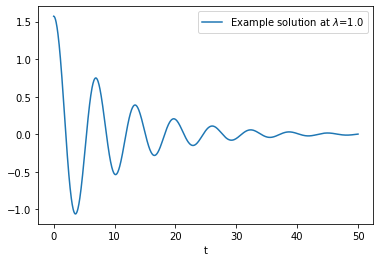

In [9]:
plt.plot(time, sol[:,0], label=f'Example solution at $\lambda$={λ}')
plt.xlabel('t')
plt.legend()

### Build the surrogate

In [10]:
# define the parameter discretization
param = np.linspace(1,5,101)

In [11]:
# build the training set
training = []
for λ in param:
    sol = odeint(pend,y0, time, (b,λ))
    training.append(sol[:,0])

In [12]:
# create the pendulum model
pendulum = ROM(training, time, param, greedy_tol=1e-14, poly_deg=5)

In [13]:
# call/build the surrogate for some parameter value
pendulum.surrogate(1.14)

array([ 1.57079633,  1.56937605,  1.56513412, ..., -0.00282289,
       -0.00331644, -0.00379569])

In [14]:
# benchmark the surrogate against the ODE solver at some parameter value
λ = 2.17
%timeit -t sol = odeint(pend,y0, time, (b,λ))

5.63 ms ± 384 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit -t pendulum.surrogate(λ)

1.35 ms ± 58.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
# name the surrogate model
surr = pendulum.surrogate

In [17]:
# look for an out-of-sample parameter
param

array([1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36, 1.4 ,
       1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72, 1.76, 1.8 , 1.84,
       1.88, 1.92, 1.96, 2.  , 2.04, 2.08, 2.12, 2.16, 2.2 , 2.24, 2.28,
       2.32, 2.36, 2.4 , 2.44, 2.48, 2.52, 2.56, 2.6 , 2.64, 2.68, 2.72,
       2.76, 2.8 , 2.84, 2.88, 2.92, 2.96, 3.  , 3.04, 3.08, 3.12, 3.16,
       3.2 , 3.24, 3.28, 3.32, 3.36, 3.4 , 3.44, 3.48, 3.52, 3.56, 3.6 ,
       3.64, 3.68, 3.72, 3.76, 3.8 , 3.84, 3.88, 3.92, 3.96, 4.  , 4.04,
       4.08, 4.12, 4.16, 4.2 , 4.24, 4.28, 4.32, 4.36, 4.4 , 4.44, 4.48,
       4.52, 4.56, 4.6 , 4.64, 4.68, 4.72, 4.76, 4.8 , 4.84, 4.88, 4.92,
       4.96, 5.  ])

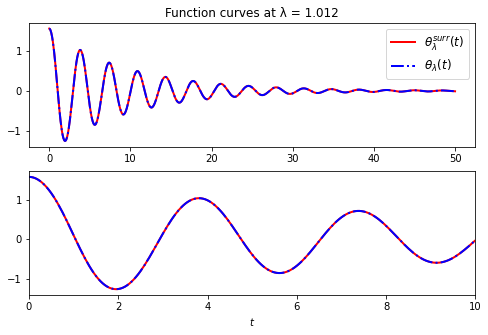

In [18]:
# plot out-of-sample functions at λ = 3.42
par = 3.42
sol = odeint(pend,y0, time, (b,par))[:,0]
fig, ax = plt.subplots(2,1, figsize=(8,5))
ax[0].plot(time, surr(par), 'r', lw=2, label='$θ_λ^{surr}(t)$')
ax[0].plot(time, sol, 'b-.', lw=2, label='$θ_λ(t)$')
ax[1].plot(time, surr(par), 'r', lw=2, label='$θ_λ^{surr}(t)$')
ax[1].plot(time, sol, 'b-.', lw=2, label='$θ_λ(t)$')
ax[1].set(xlim=(0,10))
ax[1].set(xlabel='$t$')
ax[0].set_title('Function curves at λ = 1.012')
ax[0].legend(fontsize = 'large')

### Benchmarks

Perform a benchmark measuring the $L_2$ error of the surrogate against a dense validation set of true solutions

In [19]:
# name the norm tool from the integration object
norm = pendulum.integration.norm
# create a dense validation set (10x the size of the training set)
param_val = np.linspace(1,5,1001)
# compute errors
errors = []
for λ in param_val:
    sol = odeint(pend,y0, time, (b,λ))[:,0]
    errors.append(norm(sol - surr(λ)))

Text(0.5, 1.0, 'Validation errors')

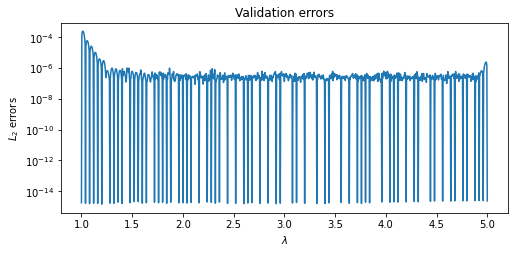

In [20]:
# plot errors
fig = plt.figure(figsize=(8,3.5))
plt.semilogy(param_val, errors, lw=1.5)
plt.xlabel('$λ$')
plt.ylabel('$L_2$ errors')
plt.title('Validation errors')

What is the parameter corresponding to the largest error?

In [21]:
worst_lambda = param_val[np.argmax(errors)]

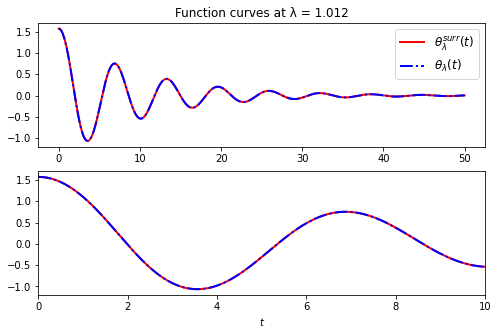

In [22]:
# plot the overlap between the surrogate and the true solution model
# at the worst parameter
par = worst_lambda
sol = odeint(pend,y0, time, (b,par))[:,0]
fig, ax = plt.subplots(2,1, figsize=(8,5))
ax[0].plot(time, surr(par), 'r', lw=2, label='$θ_λ^{surr}(t)$')
ax[0].plot(time, sol, 'b-.', lw=2, label='$θ_λ(t)$')
ax[1].plot(time, surr(par), 'r', lw=2, label='$θ_λ^{surr}(t)$')
ax[1].plot(time, sol, 'b-.', lw=2, label='$θ_λ(t)$')
ax[1].set(xlim=(0,10))
ax[1].set(xlabel='$t$')
ax[0].set_title(f'Function curves at λ = {worst_lambda}')
ax[0].legend(fontsize = 'large')

We see from this plot that the curves are indistinguishable to eye-resolution.